# Asignment 1: Language models

## Instructions
- Learn how to use BERT, GPT, or T5 large language models.
- Select a publicly available text classification dataset in a language of your choice (hate speech, sarcasm, depression or other interesting topic in agreement with the instructor) from, e.g., Kaggle or Google dataset search.
- Compare the performance of two different types of fine-tuned large language models (e.g.,  fine-tuned BERT model with fine-tuned T5 model) .
- Prepare the code as a Jupyter notebook.
- Prepare a short report of your work (the data set, parameters used, results, analysis) on max. 2 pages

## Data preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# this was used to convert original files to simpler csv fomat ready for pandas
def read_from_file(file_name: str):
    data = []
    with open(file_name, 'r') as fp:
        for line in fp:
            if line.startswith('###'):
                continue

            if not line.strip():
                continue

            label, text = line.split('\t')
            data.append((label, text.strip()))
    return data 


# prepare train data
df = pd.read_csv('data/train.csv', sep=',')
# drop missing rows if any
df = df.dropna(subset = ['text'])


# prepare validation data
df_validate = pd.read_csv('data/dev.csv', sep=',')
df_validate = df_validate.dropna(subset = ['text'])

# prepare test data
df_test = pd.read_csv('data/test.csv', sep=',')
df_test = df_test.dropna(subset = ['text'])

# print senatance counts
print('Number of train sentences: {:,}\n'.format(df.shape[0]))
print('Number of validate sentences: {:,}\n'.format(df.df_validate[0]))
print('Number of test sentences: {:,}`n'.format(df_test.shape[0]))

(180040, 2) (30212, 2) (30135, 2)


# Data exploration

In [4]:
df.head()

,label,text
0,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...
1,METHODS,A total of 125 patients with primary knee OA w...
2,METHODS,Outcome measures included pain reduction and i...
3,METHODS,Pain was assessed using the visual analog pain...
4,METHODS,Secondary outcome measures included the Wester...


In [34]:
# check class distribution
df['label'].value_counts(normalize=True)

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: label, dtype: float64

Max text length: 296
Min text length: 1
99 quantile : 80.0


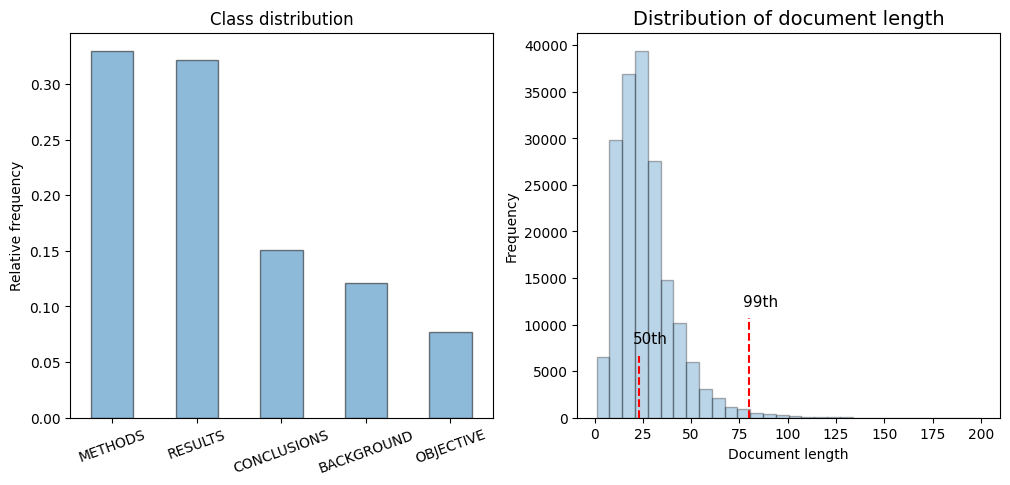

In [47]:
# print(df[df['text'].str.split().str.len() > 250])
# df.iloc[71510]['text']


# fig, ax = plt.subplots(figsize = (6,4))
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))


# plot class distribution
df['label'].value_counts(normalize=True).plot(kind='bar', alpha=0.5, edgecolor='black', rot=20, ylabel='Relative frequency',title='Class distribution', ax=ax[0])


doc_lengths = pd.Series([len(i.split()) for i in df['text']])
print('Max text length:', max(doc_lengths))
print('Min text length:', min(doc_lengths))
print('99 quantile :', doc_lengths.quantile(0.99))

# plot document length distribution
ax[1].hist(doc_lengths[doc_lengths <= 200], bins=30, density=False, alpha=0.3, edgecolor='black')


# Calculate percentiles
quant_50, quant_99 = doc_lengths.quantile(0.50), doc_lengths.quantile(0.99)
quants = [[quant_50, 0.6, 0.16], [quant_99, 0.8, 0.26]]
for i in quants:
    ax[1].axvline(i[0], alpha = 1, ymax = i[2], linestyle = "--", color='red')

ax[1].text(quant_50-3, 8000, "50th", size = 11, alpha = 1)
ax[1].text(quant_99-3, 12000, "99th", size = 11, alpha = 1)

ax[1].set_title("Distribution of document length", size = 14)
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Document length")

plt.savefig("data.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Analysis using BERT langugage model fine-tuned for sequence classification

In [7]:
from datasets import Dataset
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

encoding = tokenizer.encode(df['text'][0], truncation=True, padding=True, max_length=80)

sample = df['text'][0].replace('\n', ' ')
print(f"{sample}...")
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))

label2id = {'METHODS': 0, 'RESULTS': 1, 'CONCLUSIONS': 2, 'BACKGROUND': 3, 'OBJECTIVE': 4}
id2label = ['METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'OBJECTIVE']

def preprocess_function(examples):
    result = tokenizer(examples['text'], truncation=True, padding=True, max_length=80)
    result['label'] = [label2id[l] for l in examples['label']]
    return result

train_dataset = Dataset.from_pandas(df)
validation_dataset = Dataset.from_pandas(df_validate)
test_dataset = Dataset.from_pandas(df_test)

# dataset = dataset.train_test_split(test_size=0.3)
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True) 
encoded_validation_dataset = validation_dataset.map(preprocess_function, batched=True) 
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)


To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) ....
[101, 1706, 8242, 1103, 23891, 1104, 127, 2277, 1104, 3828, 1822, 118, 13753, 9619, 3073, 22834, 1548, 12805, 1673, 1107, 9248, 2489, 117, 16178, 117, 1105, 27410, 1822, 118, 3654, 24970, 1107, 1103, 1603, 1858, 1105, 2480, 1103, 2629, 1156, 1129, 8505, 1120, 1367, 2277, 1107, 2214, 6323, 1114, 8828, 1106, 5199, 5656, 184, 13894, 19243, 1582, 7729, 1548, 113, 152, 1592, 114, 119, 102]
['[CLS]', 'To', 'investigate', 'the', 'efficacy', 'of', '6', 'weeks', 'of', 'daily', 'low', '-', 'dose', 'oral', 'pre', '##dn', '##is', '##olo', '##ne', 'in', 'improving', 'pain', ',', 'mobility', ',', 'and', 'systemic', 'low', '-', 'grade', 'inflammation', 'in', 'the', 'short', 'term', 'and', 'whether', 'the', 'effect', 'wo

Map:   0%|          | 0/180040 [00:00<?, ? examples/s]

Map:   0%|          | 0/30212 [00:00<?, ? examples/s]

Map:   0%|          | 0/30135 [00:00<?, ? examples/s]

In [11]:
import gc
import torch
import numpy as np 

from transformers import  BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# clear GPU memory
trainer = None
model = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(id2label))
model.cuda()


# import evaluate
# precision_metric = evaluate.load("precision")
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=-1)
#     return precision_metric.compute(predictions=predictions, references=labels)


# eval strategy
def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = np.argmax(predictions, axis=1)

   accuracy = accuracy_score(y_true=labels, y_pred=predictions)
   recall = recall_score(y_true=labels, y_pred=predictions, average='weighted')
   precision = precision_score(y_true=labels, y_pred=predictions, average='weighted')
   f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')
   return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


training_args = TrainingArguments(
    output_dir="final_model_bert",
    # learning_rate=2e-5,
    num_train_epochs=4,
    evaluation_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    # save_steps=100,
    # eval_steps=100,
    # logging_steps=100,
    disable_tqdm=True,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 32,
    save_total_limit = 3,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_validation_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

)

trainer.train()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

{'loss': 0.5811, 'learning_rate': 4.888928381020082e-05, 'epoch': 0.09}
{'eval_loss': 0.49539026618003845, 'eval_accuracy': 0.8220574606116775, 'eval_precision': 0.8405922714143468, 'eval_recall': 0.8220574606116775, 'eval_f1': 0.8198286254833546, 'eval_runtime': 84.8188, 'eval_samples_per_second': 356.194, 'eval_steps_per_second': 11.141, 'epoch': 0.09}
{'loss': 0.4483, 'learning_rate': 4.777856762040164e-05, 'epoch': 0.18}
{'eval_loss': 0.4754386842250824, 'eval_accuracy': 0.8244737190520323, 'eval_precision': 0.8432341524950471, 'eval_recall': 0.8244737190520323, 'eval_f1': 0.8244189619645627, 'eval_runtime': 83.6655, 'eval_samples_per_second': 361.105, 'eval_steps_per_second': 11.295, 'epoch': 0.18}
{'loss': 0.4309, 'learning_rate': 4.666785143060245e-05, 'epoch': 0.27}
{'eval_loss': 0.39537280797958374, 'eval_accuracy': 0.8590295246921753, 'eval_precision': 0.856131854379345, 'eval_recall': 0.8590295246921753, 'eval_f1': 0.8572053987367394, 'eval_runtime': 84.5997, 'eval_samples_p

TrainOutput(global_step=8500, training_loss=0.38941084379308366, metrics={'train_runtime': 3756.842, 'train_samples_per_second': 191.693, 'train_steps_per_second': 5.991, 'train_loss': 0.38941084379308366, 'epoch': 1.51})

### Evaluate on validation data

In [12]:
eval_results = trainer.evaluate()

{'eval_loss': 0.3577435314655304, 'eval_accuracy': 0.8725340924136105, 'eval_precision': 0.8737945258861806, 'eval_recall': 0.8725340924136105, 'eval_f1': 0.8717285514093978, 'eval_runtime': 81.0314, 'eval_samples_per_second': 372.843, 'eval_steps_per_second': 11.662, 'epoch': 1.51}


### Evaluate on test data

In [51]:
# Predictions
predictions = trainer.predict(encoded_test_dataset)

# print metrics
predictions[2]

{'test_loss': 0.3901568651199341,
 'test_accuracy': 0.8628173220507716,
 'test_precision': 0.8645966545933981,
 'test_recall': 0.8628173220507716,
 'test_f1': 0.8620222763067675,
 'test_runtime': 81.2939,
 'test_samples_per_second': 370.692,
 'test_steps_per_second': 11.588}

## Analysis using GPT langugage model fine-tuned for sequence classification

In [78]:
from transformers import GPT2Tokenizer

label2id = {'METHODS': 0, 'RESULTS': 1, 'CONCLUSIONS': 2, 'BACKGROUND': 3, 'OBJECTIVE': 4}
id2label = ['METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND', 'OBJECTIVE']


gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.padding_side = "left"
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token

def gpt_preprocess_function(examples):
    result = gpt_tokenizer(examples['text'], truncation=True, padding=True, max_length=80)
    result['label'] = [label2id[l] for l in examples['label']]
    return result

gpt_encoded_train_dataset = train_dataset.map(preprocess_function, batched=True) 
gpt_encoded_validation_dataset = validation_dataset.map(preprocess_function, batched=True) 
gpt_encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)



Map:   0%|          | 0/180040 [00:00<?, ? examples/s]

Map:   0%|          | 0/30212 [00:00<?, ? examples/s]

Map:   0%|          | 0/30135 [00:00<?, ? examples/s]

In [81]:
from transformers import GPT2ForSequenceClassification

# clear GPU memory
trainer = None
model = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()


model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(id2label))
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(gpt_tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
model.cuda()


training_args = TrainingArguments(
    output_dir="final_model_gpt",
    # learning_rate=2e-5,
    num_train_epochs=4,
    evaluation_strategy="steps",
    logging_strategy="steps",
    save_strategy="steps",
    # save_steps=100,
    # eval_steps=100,
    # logging_steps=100,
    disable_tqdm=True,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 32,
    save_total_limit = 3,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=gpt_encoded_train_dataset,
    eval_dataset=gpt_encoded_validation_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]

)

trainer.train()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/jaka/miniconda3/envs/ml4lg/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.125, 'learning_rate': 4.888928381020082e-05, 'epoch': 0.09}
{'eval_loss': 0.7682552337646484, 'eval_accuracy': 0.701277638024626, 'eval_precision': 0.73167225224225, 'eval_recall': 0.701277638024626, 'eval_f1': 0.7039653563576614, 'eval_runtime': 87.6744, 'eval_samples_per_second': 344.593, 'eval_steps_per_second': 10.779, 'epoch': 0.09}
{'loss': 0.73, 'learning_rate': 4.777856762040164e-05, 'epoch': 0.18}
{'eval_loss': 0.6780767440795898, 'eval_accuracy': 0.747616840990335, 'eval_precision': 0.7621467430447444, 'eval_recall': 0.747616840990335, 'eval_f1': 0.7438172452926123, 'eval_runtime': 88.7452, 'eval_samples_per_second': 340.435, 'eval_steps_per_second': 10.648, 'epoch': 0.18}
{'loss': 0.6496, 'learning_rate': 4.666785143060245e-05, 'epoch': 0.27}
{'eval_loss': 0.5925609469413757, 'eval_accuracy': 0.7785317092546008, 'eval_precision': 0.777506564259446, 'eval_recall': 0.7785317092546008, 'eval_f1': 0.7743504963502791, 'eval_runtime': 88.648, 'eval_samples_per_second': 

TrainOutput(global_step=17500, training_loss=0.48562076590401787, metrics={'train_runtime': 8533.3458, 'train_samples_per_second': 84.394, 'train_steps_per_second': 2.638, 'train_loss': 0.48562076590401787, 'epoch': 3.11})

### Evaluate on validation data

In [82]:
gpt_eval_results = trainer.evaluate()

{'eval_loss': 0.43423569202423096, 'eval_accuracy': 0.844101681451079, 'eval_precision': 0.8441534414547268, 'eval_recall': 0.844101681451079, 'eval_f1': 0.8418152333397635, 'eval_runtime': 86.0341, 'eval_samples_per_second': 351.163, 'eval_steps_per_second': 10.984, 'epoch': 3.11}


### Evaluate on test data

In [83]:
# Predictions
gpt_predictions = trainer.predict(gpt_encoded_test_dataset)

# print metrics
predictions[2]

{'test_loss': 0.3901568651199341,
 'test_accuracy': 0.8628173220507716,
 'test_precision': 0.8645966545933981,
 'test_recall': 0.8628173220507716,
 'test_f1': 0.8620222763067675,
 'test_runtime': 81.2939,
 'test_samples_per_second': 370.692,
 'test_steps_per_second': 11.588}